In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fast_control.viz.episodic_plot import *
from fast_control.viz.plot import *
from fast_control.gps import (
    ADKernel,
    ADPKernel,
    ADPRandomFeatures,
    ADRandomFeatures,
    ADPRFSketch,
    ADRFOne,
)
import sys
import mosek
import numpy as np
import pickle
np.set_printoptions(threshold=sys.maxsize)

In [9]:
# import train_test_split function
from sklearn.model_selection import train_test_split

# load adp_kernel data
with open('data/50/raw_episodic_data.pkl', 'rb') as f:
    data = pickle.load(f)
xs, ys , zs = data['adp_kernel'] 

# test/train split
x_train, x_test, y_train, y_test, z_train, z_test = \
    train_test_split(np.asarray(xs), np.asarray(ys), np.asarray(zs), test_size=0.25, shuffle=False)
print(zs.shape) #10152
print(z_test.shape) #2538


(2538,)


In [10]:
#init_gp_dict, init_gp, train and test gp
def init_gp_dict(xs, ys, zs, gps_names):
    """Initialize gp dictionary."""
    data = dict.fromkeys(gps_names)
    for gp_name in gps_names:
        data[gp_name] = (np.copy(xs), np.copy(ys), np.copy(zs))
    return data


def init_gp(gp_name, datum, rf_d):
    """Initialize specified kernel."""
    if gp_name == ADRandomFeatures.name:
        return ADRandomFeatures(*datum, 2 * rf_d)
    elif gp_name == ADPRandomFeatures.name:
        return ADPRandomFeatures(*datum, 2 * rf_d)
    elif gp_name == ADKernel.name:
        return ADKernel(*datum)
    elif gp_name == ADPKernel.name:
        return ADPKernel(*datum)
    elif gp_name == ADPRFSketch.name:
        return ADPRFSketch(*datum, rf_d)
    elif gp_name == ADRFOne.name:
        return ADRFOne(*datum, rf_d)
    
def train_gps(data, rf_d):
    """Wrapper for init_gps"""
    gps = []
    for gp_name, datum in data.items():
        gp = init_gp(gp_name, datum, rf_d)
        gp.train()
        gps.append(gp)
    return gps


In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn
#train rf_gps
gps_names =['adp_rf','ad_rf']
data = init_gp_dict(x_train, y_train, z_train, gps_names)
mse = np.empty([2,25])
mae = np.empty([2,25])
for num in range(25):
    gps = train_gps(data,100*(num+1))
    for i,gp in enumerate(gps):
        z_pred = gp.test(x_test, y_test)
        mse[i,num] = mean_squared_error(z_test, z_pred)
        mae[i,num] = mean_absolute_error(z_test, z_pred)
        # print('mse of {} is {}'.format(gps_names[i],mse[i,num]))
        # print('mae of {} is {}'.format(gps_names[i],mae[i,num]))
#plot mse and mae in one figure using seaborn



        
    

mse of adp_rf is 2.2470174687264217
mse of ad_rf is 2.2443801734680426
mse of adp_rf is 2.03051866670703
mse of ad_rf is 2.4035567347025086
mse of adp_rf is 2.152008210017917
mse of ad_rf is 2.148206826448085
mse of adp_rf is 2.1801253297624776
mse of ad_rf is 2.252528552838756
mse of adp_rf is 2.0888509547178162
mse of ad_rf is 2.1370633656327627
mse of adp_rf is 2.0217740491853227
mse of ad_rf is 2.094031197073627
mse of adp_rf is 2.0468510966774747
mse of ad_rf is 2.1000321794230965
mse of adp_rf is 2.0081179894122707
mse of ad_rf is 2.156225896754006
mse of adp_rf is 2.0595097881797337
mse of ad_rf is 2.091938896669333
mse of adp_rf is 2.095652209386819
mse of ad_rf is 2.103927691751309
mse of adp_rf is 2.0746265396261054
mse of ad_rf is 2.0686998993594083
mse of adp_rf is 2.0327780655608723
mse of ad_rf is 2.03940186133327
mse of adp_rf is 2.023839066609391
mse of ad_rf is 2.100081595617509
mse of adp_rf is 2.052094370391052
mse of ad_rf is 2.072448812250821
mse of adp_rf is 2.039

: 

: 

In [33]:
import seaborn as sns 
sns.set()
def plot(data,name):
    xs = np.arange(100,3100,100)
    # xs = np.broadcast_to(xs[:, np.newaxis], data.shape[1:]).flatten()   
    xs = np.tile(xs, 10)
    plt.figure()
    sns.lineplot(
        x=xs,
        y=data[0, :,:].flatten("F"),
        estimator=np.median,
        errorbar=lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75)),
        label="adp_rf",
    )
    sns.lineplot(
        x=xs,
        y=data[1, :,:].flatten("F"),
        estimator=np.median,
        errorbar=lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75)),
        label="ad_rf",
    )
    sns.lineplot(x=xs, y=data[2, :, :].flatten("F"), label="adp_kernel")
    plt.xlabel("number of random features")
    plt.ylabel(f"{name}")
    plt.tight_layout()
    plt.legend()
    plt.savefig(f"data/50/rf_test_{name}_adpkernel.png", dpi=300)
    plt.show()
    

(3, 30, 10)


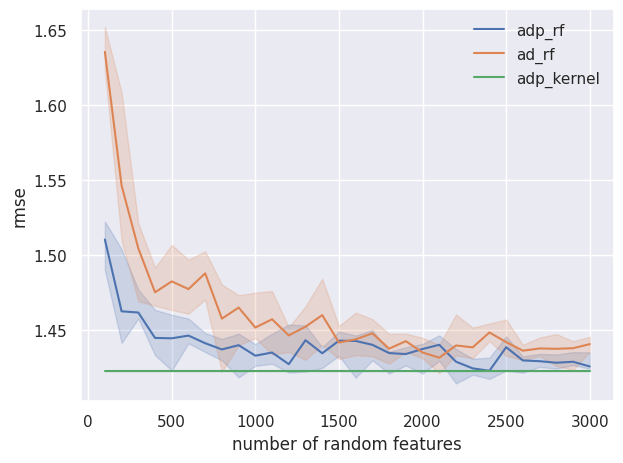

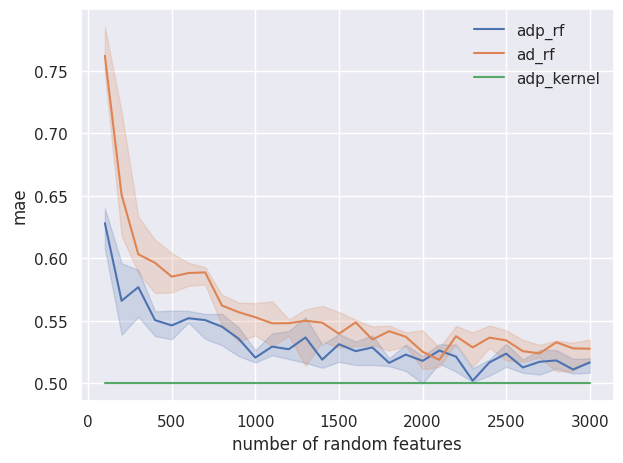

In [34]:
rmse = np.load("data/50/rf_test_rmse_10_tests.npy")
mae = np.load("data/50/rf_test_mae_10_tests.npy")
print(rmse.shape)
plot(rmse, "rmse")
plot(mae, "mae")